In [15]:
import xml.etree.ElementTree as ET
import itertools
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.base import TransformerMixin
data = []
target = []
test_data = []
test_target = []
categories = ["current", "past", "non", "unknown"]

In [16]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    sns.heatmap(cm)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [3]:
def parsetrain(filename):
    tree = ET.parse(filename)
    #this filename can be changed to accommodate different smoker files
    root = tree.getroot()

    for element in root.findall('RECORD'):
        text = str(element.find('TEXT').text)[50:]
        data.append(text)
        s= str(element.find("SMOKING").attrib['STATUS'])
        if "UNK" in s:
            target.append(4)
        elif "NON" in s:
            target.append(3)
        elif "PAST" in s:
            target.append(2)
        else:
            target.append(1)
            
def parsetest(filename):
    tree = ET.parse(filename)
    #this filename can be changed to accommodate different smoker files
    root = tree.getroot()

    for element in root.findall('RECORD'):
        text = str(element.find('TEXT').text)[50:]
        test_data.append(text)
        s= str(element.find("SMOKING").attrib['STATUS'])
        if "UNK" in s:
            test_target.append(4)
        elif "NON" in s:
            test_target.append(3)
        elif "PAST" in s:
            test_target.append(2)
        else:
            test_target.append(1)

In [4]:
parsetrain('smokers_surrogate_train_all_version2.xml')
parsetest('smokers_surrogate_test_all_groundtruth_version2.xml')

In [5]:
#TFIDF feature extraction - will be used for the rest of the tests
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, target)

0.605769230769
Normalized confusion matrix
[[ 0.21428571  0.07142857  0.21428571  0.5       ]
 [ 0.          0.          0.27272727  0.72727273]
 [ 0.          0.          0.5         0.5       ]
 [ 0.01587302  0.01587302  0.14285714  0.82539683]]


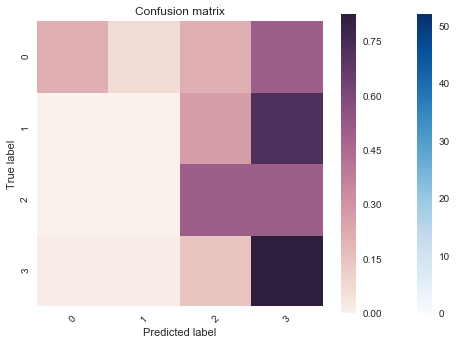

In [6]:
text_clf = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(2,4))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB(alpha=1e-3)),
])
_ = text_clf.fit(data, target)
predicted = text_clf.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)

0.653846153846
Normalized confusion matrix
[[ 0.21428571  0.07142857  0.21428571  0.5       ]
 [ 0.          0.          0.27272727  0.72727273]
 [ 0.          0.          0.5         0.5       ]
 [ 0.01587302  0.          0.07936508  0.9047619 ]]


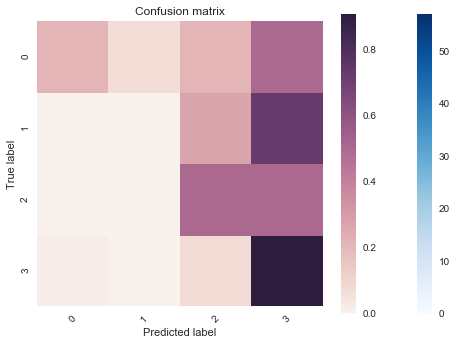

In [7]:
text_clf_ber = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(2,4))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', BernoulliNB(alpha =1e-3,binarize = None)),
])
_ = text_clf_ber.fit(data, target)
predicted = text_clf_ber.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)

0.605769230769
Normalized confusion matrix
[[ 0.          0.          0.          1.        ]
 [ 0.          0.          0.18181818  0.81818182]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.          0.          1.        ]]


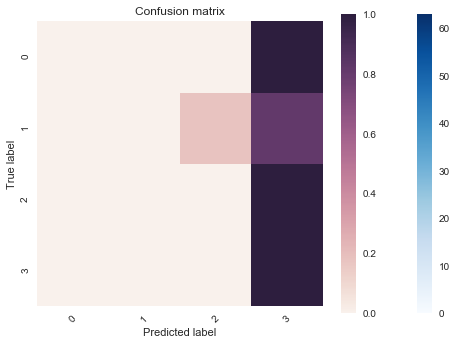

In [8]:
text_clf_svm = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, ngram_range=(1,4), stop_words='english')),
                     ('tfidf', TfidfTransformer()), 
                     ('clf', SGDClassifier(loss='log', penalty='elasticnet', alpha=1e-3, n_iter=500, random_state=42)),
])
_ = text_clf_svm.fit(data, target)
predicted = text_clf_svm.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)
#linear classifier, only predicts unknown and known

0.644230769231
Normalized confusion matrix
[[ 0.07142857  0.          0.28571429  0.64285714]
 [ 0.09090909  0.          0.36363636  0.54545455]
 [ 0.          0.          0.4375      0.5625    ]
 [ 0.          0.          0.06349206  0.93650794]]


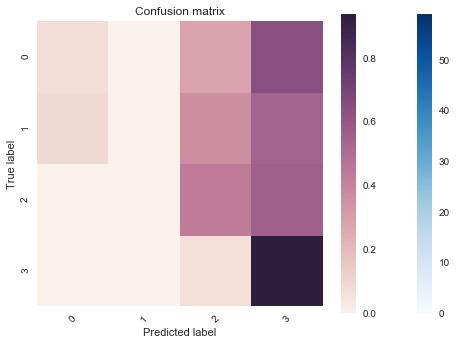

In [9]:
text_clf_rdf = Pipeline([('vect', CountVectorizer(max_df=0.95, min_df=2, ngram_range=(2,5), stop_words='english')),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state = 12)),
])
_ = text_clf_rdf.fit(data, target)
predicted = text_clf_rdf.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
#print(predicted)
#random forest

0.605769230769
Normalized confusion matrix
[[ 0.07142857  0.14285714  0.35714286  0.42857143]
 [ 0.09090909  0.27272727  0.45454545  0.18181818]
 [ 0.375       0.125       0.25        0.25      ]
 [ 0.03174603  0.04761905  0.04761905  0.87301587]]


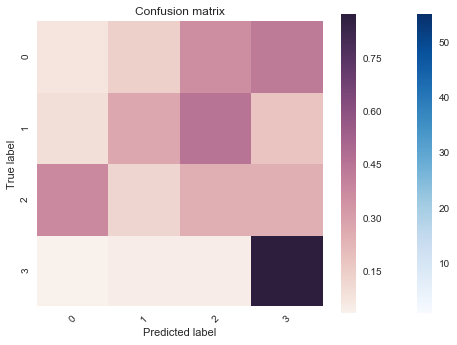

In [10]:
text_clf_dct = Pipeline([('vect', CountVectorizer(analyzer = "word", ngram_range=(2,4),max_df=0.95, min_df=2, stop_words='english')),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', tree.DecisionTreeClassifier(class_weight = "balanced")),
])
_ = text_clf_dct.fit(data, target)
predicted = text_clf_dct.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
plt.show()
#print(predicted)

0.153846153846
Normalized confusion matrix
[[ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  1.  0.]]


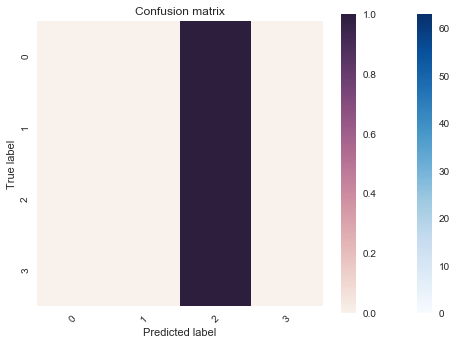

In [11]:
text_clf_svc = Pipeline([('vect', CountVectorizer(analyzer = "char", max_df=0.95, min_df=2, ngram_range=(2,4), stop_words='english')),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', SVC(C=10.0, cache_size=200, class_weight="balanced", coef0=0.0,
    decision_function_shape=None, degree=3, gamma='auto', kernel='rbf', probability=True, random_state=12, shrinking=True,
    tol=0.001, verbose=False)),
])
_ = text_clf_svc.fit(data, target)
predicted = text_clf_svc.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)
plt.show()

0.519230769231
Normalized confusion matrix
[[ 0.          0.14285714  0.5         0.35714286]
 [ 0.27272727  0.09090909  0.54545455  0.09090909]
 [ 0.          0.1875      0.75        0.0625    ]
 [ 0.03174603  0.06349206  0.25396825  0.65079365]]


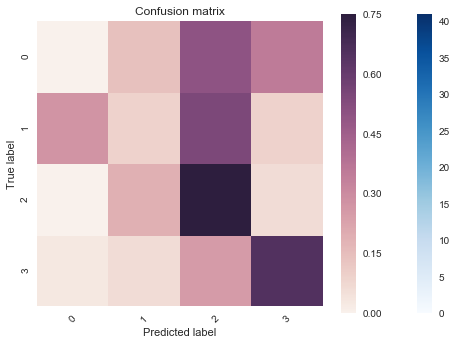

In [12]:
text_clf_reg = Pipeline([('vect', CountVectorizer(analyzer = "char", max_df=0.95, min_df=2, ngram_range=(2,4))),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(multi_class="multinomial",max_iter=200,solver="lbfgs",tol=0.01,class_weight="balanced")),
])
_ = text_clf_reg.fit(data, target)
predicted = text_clf_reg.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)

In [23]:
text_clf_gbc = Pipeline([('vect', CountVectorizer(analyzer = "char", max_df=0.95, min_df=2, ngram_range=(2,4))),
                         ('to_dense', DenseTransformer()),
                         ('tfidf', TfidfTransformer()), 
                         ('clf', GradientBoostingClassifier(n_estimators = 500)),
])
_ = text_clf_gbc.fit(data, target)
predicted = text_clf_gbc.predict(test_data)
print(np.mean(predicted == test_target))
plot_confusion_matrix(confusion_matrix(test_target,predicted),classes=[1,2,3,4],normalize=True)

ValueError: empty vocabulary; perhaps the documents only contain stop words

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, ngram_range=(2,4))
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names()

lda = LatentDirichletAllocation(n_topics=10, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)